In [2]:
# Install required library
!pip install pyarrow

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency

# Load dataset
from google.colab import files
uploaded = files.upload()  # Upload the file manually in Colab

df = pd.read_parquet('green_tripdata_2023-01.parquet')
print(df.info())  # Display dataset information


Saving green_tripdata_2023-01.parquet to green_tripdata_2023-01.parquet
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68211 entries, 0 to 68210
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               68211 non-null  int64         
 1   lpep_pickup_datetime   68211 non-null  datetime64[us]
 2   lpep_dropoff_datetime  68211 non-null  datetime64[us]
 3   store_and_fwd_flag     63887 non-null  object        
 4   RatecodeID             63887 non-null  float64       
 5   PULocationID           68211 non-null  int64         
 6   DOLocationID           68211 non-null  int64         
 7   passenger_count        63887 non-null  float64       
 8   trip_distance          68211 non-null  float64       
 9   fare_amount            68211 non-null  float64       
 10  extra                  68211 non-null  float64       
 11  mta_tax                68211 non-null  float64 

In [3]:
df.drop(columns=['ehail_fee'], inplace=True)


In [4]:
df['trip_duration'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60  # Convert to minutes
print(df['trip_duration'].head())


0    11.016667
1     6.766667
2     6.333333
3     5.816667
4     5.966667
Name: trip_duration, dtype: float64


In [5]:
df['weekday'] = df['lpep_dropoff_datetime'].dt.day_name()
print(df['weekday'].value_counts())


weekday
Tuesday      11246
Thursday     10183
Monday       10006
Friday        9987
Wednesday     9903
Saturday      8504
Sunday        8382
Name: count, dtype: int64


In [6]:
df['hourofday'] = df['lpep_dropoff_datetime'].dt.hour
print(df['hourofday'].value_counts())


hourofday
18    5392
16    5294
17    5183
15    4854
19    4571
14    4356
13    3839
12    3796
11    3740
10    3599
9     3532
20    3438
8     3082
21    2511
7     2314
22    2014
23    1557
0     1269
1      912
6      752
2      697
3      602
4      506
5      401
Name: count, dtype: int64


In [7]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())  # Fill numeric missing values with mean

object_cols = df.select_dtypes(include=['object']).columns
df[object_cols] = df[object_cols].fillna('Unknown')  # Fill object missing values with 'Unknown'

print(df.isnull().sum())  # Verify no missing values remain


VendorID                 0
lpep_pickup_datetime     0
lpep_dropoff_datetime    0
store_and_fwd_flag       0
RatecodeID               0
PULocationID             0
DOLocationID             0
passenger_count          0
trip_distance            0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
payment_type             0
trip_type                0
congestion_surcharge     0
trip_duration            0
weekday                  0
hourofday                0
dtype: int64


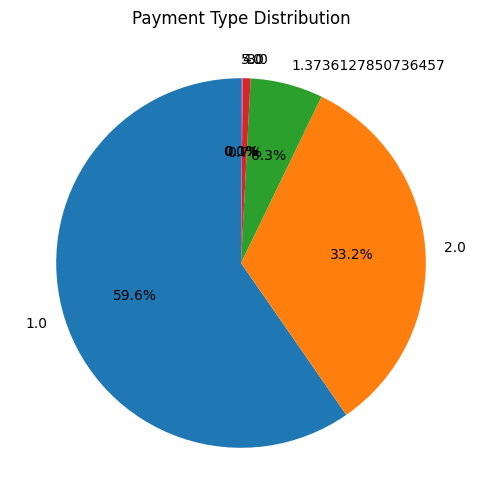

In [8]:
payment_counts = df['payment_type'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(payment_counts, labels=payment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Payment Type Distribution')
plt.show()


In [9]:
avg_total_weekday = df.groupby('weekday')['total_amount'].mean()
print(avg_total_weekday)


weekday
Friday       21.898600
Monday       21.613554
Saturday     21.652936
Sunday       21.787178
Thursday     22.131983
Tuesday      21.799532
Wednesday    21.612083
Name: total_amount, dtype: float64


In [10]:
avg_total_payment = df.groupby('payment_type')['total_amount'].mean()
print(avg_total_payment)


payment_type
1.000000    23.006171
1.373613    30.470442
2.000000    18.375641
3.000000     4.610169
4.000000     4.304737
5.000000    14.750000
Name: total_amount, dtype: float64


In [11]:
trip_type_1 = df[df['trip_type'] == 1]['total_amount']
trip_type_2 = df[df['trip_type'] == 2]['total_amount']

t_stat, p_val = ttest_ind(trip_type_1, trip_type_2, nan_policy='omit')
print(f"T-statistic: {t_stat}, P-value: {p_val}")


T-statistic: -31.896639101852312, P-value: 1.6501626398825245e-221


In [12]:
from scipy.stats import f_oneway

weekday_groups = [group['total_amount'].dropna() for _, group in df.groupby('weekday')]
# Use f_oneway for comparing multiple groups
f_stat, p_val = f_oneway(*weekday_groups)
print(f"F-statistic: {f_stat}, P-value: {p_val}")

F-statistic: 1.46115120072881, P-value: 0.18713599698476577


In [13]:
contingency_table = pd.crosstab(df['trip_type'], df['payment_type'])
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2_stat}, P-value: {p_val}")


Chi-square statistic: 68171.31009428749, P-value: 0.0


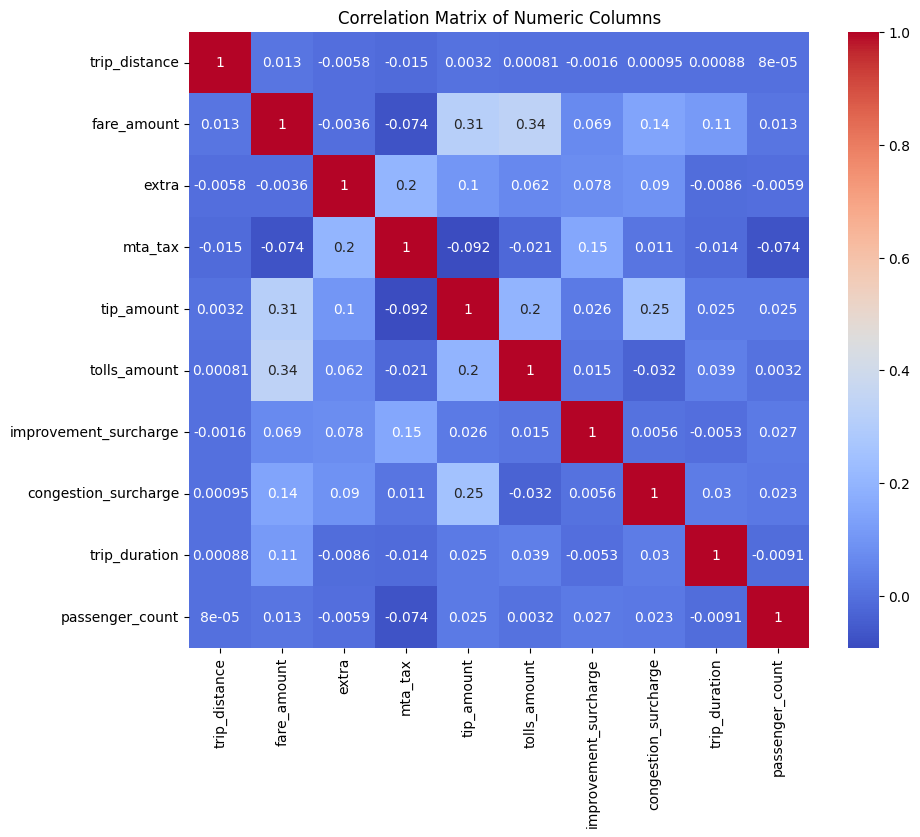

In [14]:
numeric_cols = ['trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
                'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',
                'trip_duration', 'passenger_count']

correlation_matrix = df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Columns')
plt.show()


In [15]:
object_cols = ['store_and_fwd_flag', 'RatecodeID', 'payment_type',
               'trip_type', 'weekday', 'hourofday']

df_encoded = pd.get_dummies(df, columns=object_cols)
print(df_encoded.head())


   VendorID lpep_pickup_datetime lpep_dropoff_datetime  PULocationID  \
0         2  2023-01-01 00:26:10   2023-01-01 00:37:11           166   
1         2  2023-01-01 00:51:03   2023-01-01 00:57:49            24   
2         2  2023-01-01 00:35:12   2023-01-01 00:41:32           223   
3         1  2023-01-01 00:13:14   2023-01-01 00:19:03            41   
4         1  2023-01-01 00:33:04   2023-01-01 00:39:02            41   

   DOLocationID  passenger_count  trip_distance  fare_amount  extra  mta_tax  \
0           143              1.0           2.58         14.9    1.0      0.5   
1            43              1.0           1.81         10.7    1.0      0.5   
2           179              1.0           0.00          7.2    1.0      0.5   
3           238              1.0           1.30          6.5    0.5      1.5   
4            74              1.0           1.10          6.0    0.5      1.5   

   ...  hourofday_14  hourofday_15  hourofday_16  hourofday_17  hourofday_18  \
0  ...

<ipython-input-16-2e22ff568b7e>:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[dependent_var], shade=True)


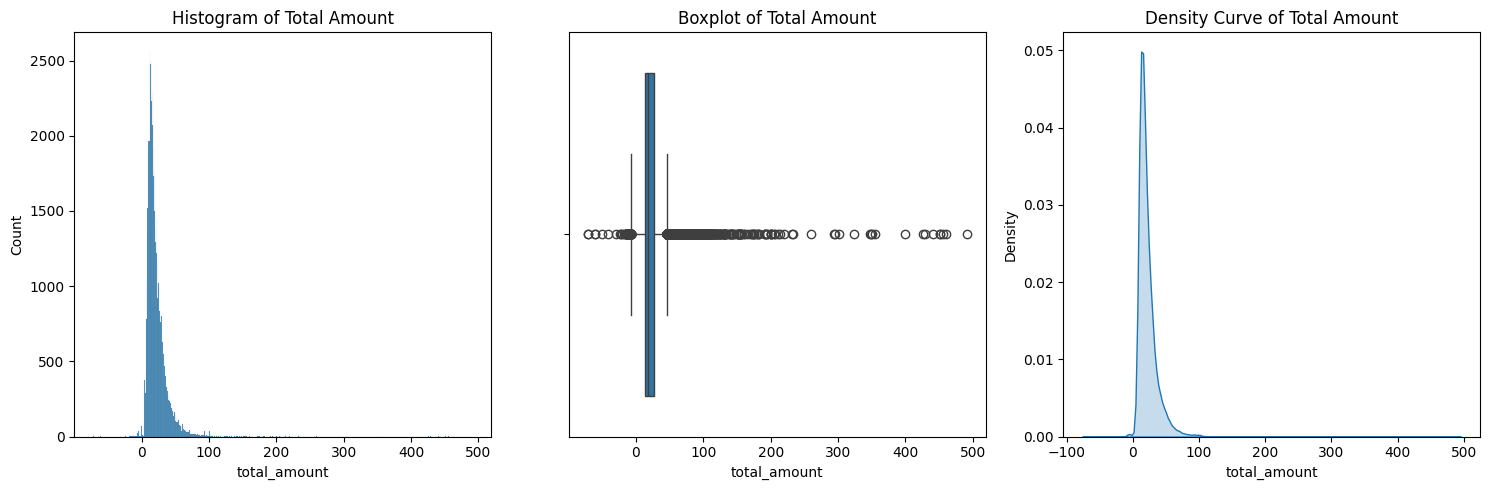

In [16]:
dependent_var = 'total_amount'

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(df[dependent_var], kde=False)
plt.title('Histogram of Total Amount')

plt.subplot(1, 3, 2)
sns.boxplot(x=df[dependent_var])
plt.title('Boxplot of Total Amount')

plt.subplot(1, 3, 3)
sns.kdeplot(df[dependent_var], shade=True)
plt.title('Density Curve of Total Amount')

plt.tight_layout()
plt.show()


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Drop datetime columns and any features directly derived from them
X = df_encoded.drop(columns=['total_amount', 'lpep_pickup_datetime', 'lpep_dropoff_datetime'])
# Assuming 'lpep_pickup_datetime', 'lpep_dropoff_datetime' are present in df_encoded

y = df_encoded['total_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

print(f"Linear Regression R^2 Score: {model_lr.score(X_test, y_test)}")

Linear Regression R^2 Score: 0.9988170564488459


In [18]:
from sklearn.tree import DecisionTreeRegressor

model_dt = DecisionTreeRegressor(random_state=42)
model_dt.fit(X_train, y_train)

print(f"Decision Tree R^2 Score: {model_dt.score(X_test, y_test)}")


Decision Tree R^2 Score: 0.9932017215857253


In [19]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

print(f"Random Forest R^2 Score: {model_rf.score(X_test, y_test)}")


Random Forest R^2 Score: 0.9960941072906594


In [20]:
from sklearn.ensemble import GradientBoostingRegressor

model_gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_gb.fit(X_train, y_train)

print(f"Gradient Boosting R^2 Score: {model_gb.score(X_test, y_test)}")


Gradient Boosting R^2 Score: 0.9968607476721577


In [21]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.5 MB/s eta 0:00:00


In [22]:
import streamlit as st
import numpy as np

# Input features from user interface (example inputs)
pickup_hour = st.slider("Pickup Hour", min_value=0, max_value=23)
passenger_count = st.number_input("Passenger Count", min_value=1)

# Create input array with zeros for all features
input_data = np.zeros(X_train.shape[1])

# Find the indices of the 'pickup_hour' and 'passenger_count' features
pickup_hour_index = X_train.columns.get_loc('hourofday_' + str(pickup_hour))  # Assumes one-hot encoding
# Instead of trying to find 'passenger_count_1', use the original 'passenger_count' column:
passenger_count_index = X_train.columns.get_loc('passenger_count')

# Set the values for the given features
input_data[pickup_hour_index] = 1  # Set one-hot encoded value for pickup hour
input_data[passenger_count_index] = passenger_count  # Set the actual passenger count value

# Predict total amount based on user input
predicted_amount = model_lr.predict([input_data])  # Note: input_data is enclosed in a list
st.write(f"Predicted Total Amount: ${predicted_amount[0]:.2f}")

2025-04-13 09:24:47.918 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 09:24:47.921 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 09:24:47.924 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 09:24:47.933 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 09:24:47.939 WARNING streamlit.runtime.state.session_state_proxy: Session state does not function when running a script without `streamlit run`
2025-04-13 09:24:47.943 WARNING streamlit.runtime.scriptrunner_utils.script_run_c

In [23]:
!pip install streamlit -q

In [24]:
!wget -q -O - ipv4.icanhazip.com

104.196.107.173


In [25]:
! streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://104.196.107.173:8501

⠙⠹⠸⠼⠴⠦Need to install the following packages:
localtunnel@2.0.2
Ok to proceed? (y) y

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸Usage: lt --port [num] <options>

Options:
  -p, --port                Internal HTTP server port                 [required]
  -h, --host                Upstream server providing forwarding
                                             [default: "https://localtunnel.me"]
  -s, --subdomain           Request this subdomain
  -l, --local-host          Tunnel traffic to this host instead of localhost,
                            override Host header to this host
      --local-https         Tunnel traffic to a local HTTPS server     [boolean]
      --local-cert          Path to certificate PEM file for local HTTPS server
      --local-key           Path to certificate key file for local HTTP

In [27]:
pip install -r requirements.txt


8501
8000
8501
